In [2]:
# gp_ddm_generator.py
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
import matplotlib.pyplot as plt

# Gaussian process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [3]:
# -------------------------
# Helper: Sigmoid-based core functions (kept from your original logic)
# -------------------------
def k_P(P, k_min=0.01, k_max=0.15, gamma=0.1, P0=32):
    return k_min + (k_max - k_min) / (1 + np.exp(-gamma * (P - P0)))

def v_P_Function(P, P1=4, k_min=0.01, k_max=0.15, gamma=0.1, P0=32):
    k = k_P(P, k_min, k_max, gamma, P0)
    return 1 / (1 + np.exp(-k * (P - P1)))

def compute_v_sigmoid(T, P, condition_key, alaph1=1.5, alaph2=-0.4, gamma=0.2):
    T_0 = 100
    k_T = 0.01
    v_T = 1 / (1 + np.exp(-k_T * (T - T_0)))
    # note: adjust k_min/k_max to reasonable defaults
    v_P = v_P_Function(P=P, P1=4, k_min=0.05, k_max=0.15, gamma=gamma, P0=32)
    v_0 = v_T * v_P * 3.0

    if condition_key == 1:  # self
        v_1 = v_0 * (1 + alaph1)
    else:
        v_1 = v_0 * (1 + alaph2)

    # small gaussian jitter around sigmoid baseline (will later add GP residual)
    v = np.random.normal(v_1, 0.5)
    return v

def compute_a_sigmoid(M, beta1=0.2, beta2=0.0):
    k = 0.01
    M_0 = 600
    a_0 = 1 / (1 + np.exp(-k * (M - M_0))) * 3
    if M > 600:
        a_1 = a_0 * (1 + beta1)
    else:
        a_1 = a_0 * (1 + beta2)
    a = np.random.normal(a_1, 0.25)
    # enforce positive
    if a <= 0.05:
        a = 0.05
    return a

# -------------------------
# GP utilities: create GP priors and sample residuals on anchor grid
# -------------------------
def build_gp(kernel=None, alpha=1e-6, random_state=None):
    if kernel is None:
        # kernel with separate length-scales could be provided as array, but RBF with scalar is OK
        kernel = C(1.0, (0.01, 10.0)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, normalize_y=False, random_state=random_state)
    return gp

def sample_gp_prior_on_anchors(gp, X_anchors, n_samples=1, random_state=None, scale=1.0):
    """
    Sample functions from GP prior at X_anchors.
    Returns shape (n_points, n_samples)
    """
    # GaussianProcessRegressor.sample_y can be called without fitting (samples from prior)
    Y = gp.sample_y(X_anchors, n_samples=n_samples, random_state=random_state)
    # Y shape: (n_points, n_samples)
    # optionally scale amplitude
    return Y * scale

# -------------------------
# DDM simulator (simple Euler-Maruyama like stepper; same design as your original)
# -------------------------
def simulate_ddm_trial(v, a, t0=0.2, z=None, delta_t=0.001, max_time_s=2.0):
    """
    Simulate one trial with drift v, boundary a, starting point z, non-decision t0.
    Returns RT (seconds) and response (1 for upper boundary, 0 for lower).
    If no decision within max_time_s, returns RT = np.nan and response = np.nan.
    """
    if z is None:
        z = a / 2.0
    evidence = float(z)
    time = 0.0
    max_steps = int(max_time_s / delta_t)
    for _ in range(max_steps):
        # drift component per step
        instantaneous_evidence = v * delta_t
        noise = norm.rvs(loc=0, scale=1.0) * np.sqrt(delta_t)
        evidence += instantaneous_evidence + noise
        time += delta_t
        if evidence >= a:
            RT = time + t0
            return RT, 1
        elif evidence <= 0:
            RT = time + t0
            return RT, 0
    # no decision
    return np.nan, np.nan

# -------------------------
# Main generation function
# -------------------------
def generate_data_gp(num_subjects=5, trials_per_subject=60, anchor_size=300,
                     anchor_random_state=42, gp_scale_v=0.8, gp_scale_a=0.5,
                     verbose=True):
    """
    Generate simulated dataset with GP residuals added to v and a.
    Returns a pandas DataFrame with columns:
    subject, trial, P, T, W, M, label, v, a, t0, z, RT, response
    """
    rng = np.random.RandomState(anchor_random_state)

    # anchors (design space) ranges based on your previous data generation choices
    P_min, P_max = 0, 150
    T_min, T_max = 10, 600
    W_min, W_max = 200, 1500

    # create anchor points (X anchors)
    X_anchors = rng.uniform([P_min, T_min, W_min], [P_max, T_max, W_max], size=(anchor_size, 3))

    # build GP priors for v and a residuals
    # Use different length-scales so v and a residuals can vary differently
    kernel_v = C(1.0, (0.01, 10.0)) * RBF(length_scale=[40.0, 150.0, 300.0], length_scale_bounds=(1e-2, 1e4))
    kernel_a = C(1.0, (0.01, 10.0)) * RBF(length_scale=[60.0, 200.0, 400.0], length_scale_bounds=(1e-2, 1e4))

    gp_v = build_gp(kernel=kernel_v, alpha=1e-4, random_state=anchor_random_state)
    gp_a = build_gp(kernel=kernel_a, alpha=1e-4, random_state=anchor_random_state + 1)

    # sample residual functions on anchors
    Y_v = sample_gp_prior_on_anchors(gp_v, X_anchors, n_samples=1, random_state=anchor_random_state).flatten()
    Y_a = sample_gp_prior_on_anchors(gp_a, X_anchors, n_samples=1, random_state=anchor_random_state + 1).flatten()

    # scale amplitude (so residuals are of reasonable magnitude)
    if gp_scale_v is not None:
        Y_v = Y_v * gp_scale_v
    if gp_scale_a is not None:
        Y_a = Y_a * gp_scale_a

    # build interpolators (fallback to nearest if Linear fails)
    try:
        interp_v = LinearNDInterpolator(X_anchors, Y_v, fill_value=0.0)
        interp_a = LinearNDInterpolator(X_anchors, Y_a, fill_value=0.0)
        # test small call
        _ = interp_v(X_anchors[0])
    except Exception:
        interp_v = NearestNDInterpolator(X_anchors, Y_v)
        interp_a = NearestNDInterpolator(X_anchors, Y_a)

    all_trials = []
    t0_fixed = 0.2

    # For each subject
    for subj in range(1, num_subjects + 1):
        # randomly choose subject-level P,T,W (you can also vary per trial; here we keep subject-level as your original)
        T = int(rng.randint(T_min, T_max + 1))
        P = int(rng.randint(P_min, P_max + 1))
        W = int(rng.randint(W_min, W_max + 1))
        M = T + W

        # per subject baseline a computed once (as your original)
        a_baseline = compute_a_sigmoid(M)
        if a_baseline <= 0:
            # safety
            a_baseline = 0.1

        # prepare label distribution per subject: ensure equal counts
        half = trials_per_subject // 2
        labels = ['self'] * half + ['stranger'] * half
        # if odd, add one extra label randomly
        if trials_per_subject % 2 != 0:
            extra = rng.choice(['self', 'stranger'])
            labels.append(extra)
        rng.shuffle(labels)

        trial_num = 0
        # generate trials
        for lab in labels:
            trial_num += 1
            label_code = 1 if lab == 'self' else 0

            # you used compute_v on un-normalized T,P earlier; keep that baseline
            v_sig = compute_v_sigmoid(T=T, P=P, condition_key=label_code)

            a_sig = a_baseline  # baseline threshold for subject

            # GP residuals at this trial's (P,T,W)
            x_trial = np.array([P, T, W]).reshape(1, 3)
            try:
                gp_v_res = float(interp_v(x_trial)[0])
            except Exception:
                gp_v_res = float(interp_v((P, T, W)))

            try:
                gp_a_res = float(interp_a(x_trial)[0])
            except Exception:
                gp_a_res = float(interp_a((P, T, W)))

            # combine: baseline + gp residual
            v_combined = v_sig + gp_v_res
            a_combined = a_sig + gp_a_res

            # safety: keep within reasonable ranges
            # ensure a > 0.05
            if a_combined <= 0.05:
                a_combined = 0.05
            # clip v to avoid extremely large drift
            v_combined = np.clip(v_combined, -10.0, 10.0)

            # compute z = 2 / a (as you requested)
            z_val = 2.0 / a_combined

            # simulate ddm trial
            # compute realistic max_time_s: allow up to (T + W)/1000 + 0.5 as safe cap
            max_time_s = max( (T + W) * 0.001 + 0.5, 2.0)
            RT, response = simulate_ddm_trial(v_combined, a_combined, t0=t0_fixed, z=z_val, delta_t=0.001, max_time_s=max_time_s)

            # If no decision (nan), we can treat as timeout -> RT = T+W milliseconds converted to seconds
            if np.isnan(RT):
                RT = (T + W) * 0.001  # seconds
                response = 0  # treat as lower-bound (miss) — you can change this policy

            all_trials.append({
                'subject': subj,
                'trial': trial_num,
                'P': P,
                'T': T,
                'W': W,
                'M': M,
                'label': lab,
                'v': v_combined,
                'a': a_combined,
                't0': t0_fixed,
                'z': z_val,
                'RT': RT,
                'response': int(response)
            })

        if verbose and (subj % max(1, (num_subjects // 10))) == 0:
            print(f"Generated subject {subj}/{num_subjects}")

    df = pd.DataFrame(all_trials)
    # reorder columns as requested
    df = df[['subject','trial','P','T','W','M','label','v','a','t0','z','RT','response']]
    return df




In [10]:
if __name__ == "__main__":
    import os
    import matplotlib.pyplot as plt

    # -----------------------------
    # 配置：研究参数
    # -----------------------------
    NUM_SUBJECTS = 200
    TRIALS_PER_SUBJECT = 60
    ANCHOR_SIZE = 300

    # -----------------------------
    # 配置：统一项目结构（相对路径）
    # 自动兼容 Python + Jupyter
    # -----------------------------
    try:
        BASE_DIR = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        BASE_DIR = os.getcwd()

    OUTPUT_DIR = os.path.join(BASE_DIR, "..", "..", "2_Data", "Generate_Data")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    OUTPUT_CSV = os.path.join(OUTPUT_DIR, "gp_ddm_simulation_v3-200.csv")

    # -----------------------------
    # 生成 GP-DDM 模拟数据
    # -----------------------------
    df_sim = generate_data_gp(
        num_subjects=NUM_SUBJECTS,
        trials_per_subject=TRIALS_PER_SUBJECT,
        anchor_size=ANCHOR_SIZE,
        verbose=True
    )

    print("Simulated trials (clean):", len(df_sim))
    df_sim.to_csv(OUTPUT_CSV, index=False)
    print("\nSaved CSV to:", os.path.abspath(OUTPUT_CSV))

    # -----------------------------
    # 可视化检查
    # -----------------------------
    plt.figure()
    plt.hist(df_sim['RT'], bins=60)
    plt.xlabel("RT (s)")
    plt.ylabel("Count")
    plt.title("RT histogram (GP-DDM simulated)")
    plt.tight_layout()
    plt.show()

    mean_by_label = df_sim.groupby('label')['RT'].mean().reset_index()
    print("\nMean RT by label:\n", mean_by_label)

    plt.figure()
    plt.bar(mean_by_label['label'], mean_by_label['RT'])
    plt.ylabel("Mean RT (s)")
    plt.title("Mean RT by label")
    plt.tight_layout()
    plt.show()

    acc_by_label = df_sim.groupby('label')['response'].mean().reset_index()
    acc_by_label['accuracy'] = acc_by_label['response']
    print("\nAccuracy by label:\n", acc_by_label[['label','accuracy']])

    plt.figure()
    plt.bar(acc_by_label['label'], acc_by_label['accuracy'])
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title("Accuracy by label")
    plt.tight_layout()
    plt.show()

    print("\nPreview first 10 rows:\n", df_sim.head(10))


Generated subject 20/200
Generated subject 40/200
Generated subject 60/200
Generated subject 80/200
Generated subject 100/200
Generated subject 120/200
Generated subject 140/200
Generated subject 160/200
Generated subject 180/200
Generated subject 200/200
Simulated trials (clean): 12000


PermissionError: [Errno 13] Permission denied: 'd:\\GitHub_programe\\GitHub\\Guassion-Process-Experiment-Design\\1_Code\\Python_for_Generate\\..\\..\\2_Data\\Generate_Data\\gp_ddm_simulation_v3-200.csv'

Generated subject 20/200
Generated subject 40/200
Generated subject 60/200
Generated subject 80/200
Generated subject 100/200
Generated subject 120/200
Generated subject 140/200
Generated subject 160/200
Generated subject 180/200
Generated subject 200/200
Simulated trials (clean): 12000
Saved CSV to d:\GitHub_programe\GitHub\Guassion-Process-Experiment-Design\1_Code\Python_for_Generate\gp_ddm_simulation_v3-200.csv


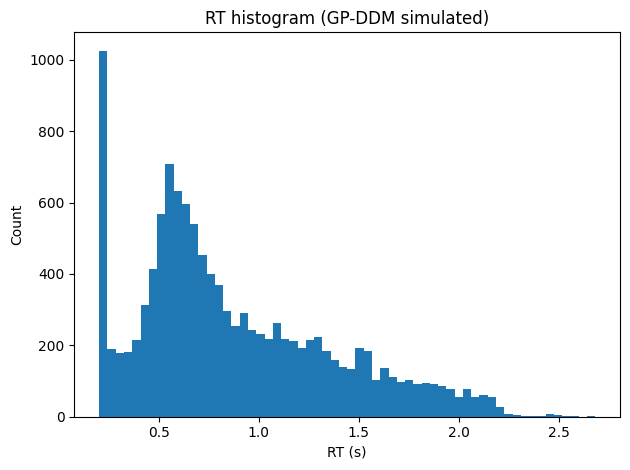

      label        RT
0      self  0.674948
1  stranger  1.074849


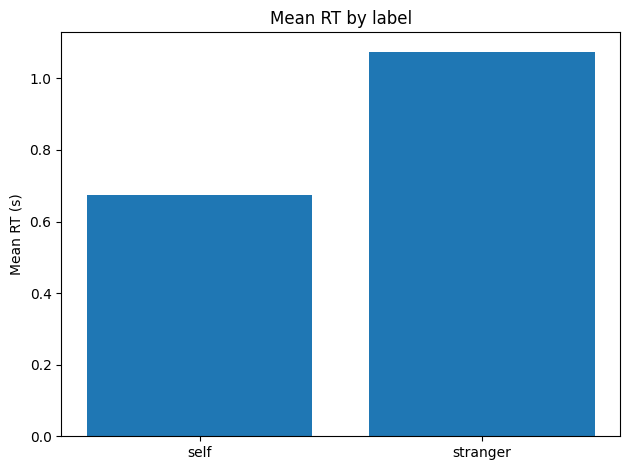

      label  accuracy
0      self  0.972333
1  stranger  0.577333


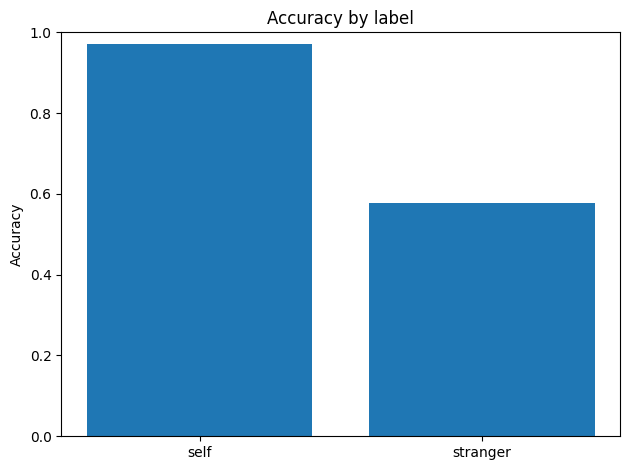

   subject  trial   P    T    W    M     label         v         a   t0  \
0        1      1  84  160  346  506  stranger  1.498968  1.228697  0.2   
1        1      2  84  160  346  506      self  4.354642  1.228697  0.2   
2        1      3  84  160  346  506  stranger -0.302952  1.228697  0.2   
3        1      4  84  160  346  506      self  4.561830  1.228697  0.2   
4        1      5  84  160  346  506      self  4.430010  1.228697  0.2   
5        1      6  84  160  346  506      self  3.451296  1.228697  0.2   
6        1      7  84  160  346  506  stranger  1.766801  1.228697  0.2   
7        1      8  84  160  346  506  stranger  0.969844  1.228697  0.2   
8        1      9  84  160  346  506      self  3.247327  1.228697  0.2   
9        1     10  84  160  346  506  stranger  1.396502  1.228697  0.2   

         z     RT  response  
0  1.62774  0.201         1  
1  1.62774  0.201         1  
2  1.62774  0.201         1  
3  1.62774  0.201         1  
4  1.62774  0.201       

In [11]:
if __name__ == "__main__":
    NUM_SUBJECTS = 200
    TRIALS_PER_SUBJECT = 60
    ANCHOR_SIZE = 300
    OUTPUT_CSV = "gp_ddm_simulation_v3-200.csv"

    df_sim = generate_data_gp(
        num_subjects=NUM_SUBJECTS,
        trials_per_subject=TRIALS_PER_SUBJECT,
        anchor_size=ANCHOR_SIZE,
        verbose=True
    )

    print("Simulated trials (clean):", len(df_sim))
    df_sim.to_csv(OUTPUT_CSV, index=False)
    print("Saved CSV to", os.path.abspath(OUTPUT_CSV))

    # --- 绘图 ---
    plt.figure()
    plt.hist(df_sim['RT'], bins=60)
    plt.xlabel("RT (s)")
    plt.ylabel("Count")
    plt.title("RT histogram (GP-DDM simulated)")
    plt.tight_layout()
    plt.show()

    # Mean RT
    mean_by_label = df_sim.groupby('label')['RT'].mean().reset_index()
    print(mean_by_label)

    plt.figure()
    plt.bar(mean_by_label['label'], mean_by_label['RT'])
    plt.ylabel("Mean RT (s)")
    plt.title("Mean RT by label")
    plt.tight_layout()
    plt.show()

    # Accuracy
    acc_by_label = df_sim.groupby('label')['response'].mean().reset_index()
    acc_by_label['accuracy'] = acc_by_label['response']
    print(acc_by_label[['label','accuracy']])

    plt.figure()
    plt.bar(acc_by_label['label'], acc_by_label['accuracy'])
    plt.ylim(0,1)
    plt.ylabel("Accuracy")
    plt.title("Accuracy by label")
    plt.tight_layout()
    plt.show()

    print(df_sim.head(10))
